In [1]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt

from scipy.integrate import trapz
from scipy.stats import gaussian_kde

from pwass.spline import MonotoneQuadraticSplineBasis
from pwass.distributions import Distribution
from pwass.dimsensionality_reduction.geodesic_pca import GeodesicPCA
from pwass.dimsensionality_reduction.nested_pca import NestedPCA
from pwass.dimsensionality_reduction.projected_pca import ProjectedPCA

In [2]:
df = pd.read_csv("data/covid_us_new.csv")
df.head(10)

,Data as of,Start week,End Week,State,Sex,Age group,COVID-19 Deaths,Total Deaths,Pneumonia Deaths,Pneumonia and COVID-19 Deaths,Influenza Deaths,"Pneumonia, Influenza, or COVID-19 Deaths",Footnote
0,12/09/2020,02/01/2020,12/05/2020,United States,All Sexes,All Ages,261530.0,2703232.0,257672.0,119560.0,6868.0,405464.0,NaN
1,12/09/2020,02/01/2020,12/05/2020,United States,All Sexes,Under 1 year,29.0,15187.0,146.0,4.0,15.0,186.0,NaN
2,12/09/2020,02/01/2020,12/05/2020,United States,All Sexes,0-17 years,133.0,26908.0,421.0,21.0,123.0,656.0,NaN
3,12/09/2020,02/01/2020,12/05/2020,United States,All Sexes,1-4 years,17.0,2823.0,92.0,2.0,42.0,149.0,NaN
4,12/09/2020,02/01/2020,12/05/2020,United States,All Sexes,5-14 years,46.0,4540.0,124.0,7.0,53.0,216.0,NaN
5,12/09/2020,02/01/2020,12/05/2020,United States,All Sexes,15-24 years,449.0,29167.0,587.0,157.0,55.0,930.0,NaN
6,12/09/2020,02/01/2020,12/05/2020,United States,All Sexes,18-29 years,1089.0,51517.0,1349.0,446.0,103.0,2085.0,NaN
7,12/09/2020,02/01/2020,12/05/2020,United States,All Sexes,25-34 years,1909.0,59676.0,2104.0,851.0,154.0,3301.0,NaN
8,12/09/2020,02/01/2020,12/05/2020,United States,All Sexes,30-49 years,11247.0,178906.0,10579.0,5095.0,574.0,17224.0,NaN
9,12/09/2020,02/01/2020,12/05/2020,United States,All Sexes,35-44 years,4917.0,84397.0,4724.0,2186.0,251.0,7676.0,NaN


In [3]:
dfs_by_state = [
    x for _, x in df.groupby(df.State) if len(x) > 1]

# optional: Remove Puerto Rico
dfs_by_state = [
    x for x in dfs_by_state if x.State.values[0] != 'Puerto Rico']

for currdf in dfs_by_state:
    currdf.loc[np.isnan(currdf["COVID-19 Deaths"].values), "COVID-19 Deaths"] = 2.0

In [4]:
nbasis = 15
zero_one_grid = np.linspace(0, 1, 100)
spline_basis = MonotoneQuadraticSplineBasis(nbasis, zero_one_grid)

In [5]:
from scipy.optimize import curve_fit

def gaussian(x, mean, amplitude, standard_deviation):
    return amplitude * np.exp( - ((x - mean) / standard_deviation) ** 2)

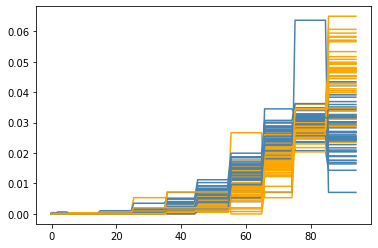

In [6]:
# create distributions
state_names = [x.State.values[0] for x in dfs_by_state]

m_distribs = []
f_distribs = []
orig_m = []
orig_f = []
bins_center = np.array([0.5, 2.5, 9.5, 19.5, 29.5, 39.5, 49.5, 59.5, 69.5, 79.5, 89.5])

bins = [[0, 1], [1, 5], [5, 15], [15, 25], [25, 35], [35, 45], [45, 55], [55, 65], [65, 75], 
        [75, 85], [85, 95]]

xgrid = np.linspace(0, 94, 101)
kept_groups = np.array([1, 3, 4, 5, 7, 9, 10, 12, 13, 14, 15])
for s in dfs_by_state:
    males = s[s.Sex == "Male"]["COVID-19 Deaths"].values[kept_groups]
    orig_m.append(males)
    interp_m = np.zeros_like(xgrid)
    assert(len(males) == len(bins))
    for i, (l, u) in enumerate(bins):
        wh = np.where((xgrid >= l) & (xgrid <= u))[0]
        interp_m[wh] = males[i]
    
    interp_m /= trapz(interp_m, xgrid)
    curr = Distribution(wbasis=spline_basis)
    curr.init_from_pdf(xgrid, interp_m)
    curr._invert_cdf()
    curr.compute_spline_expansions()
    m_distribs.append(curr)
    plt.plot(xgrid, interp_m, color="steelblue")    
 
    females = s[s.Sex == "Female"]["COVID-19 Deaths"].values[kept_groups]
    orig_f.append(females)


    interp_f = np.zeros_like(xgrid)
    for i, (l, u) in enumerate(bins):
        wh = np.where((xgrid >= l) & (xgrid <= u))[0]
        interp_f[wh] = females[i]
    
    interp_f /= trapz(interp_f, xgrid)
    curr = Distribution(wbasis=spline_basis)
    curr.init_from_pdf(xgrid, interp_f)
    curr._invert_cdf()
    curr.compute_spline_expansions()
    f_distribs.append(curr)
    plt.plot(xgrid, interp_f, color="orange")
    
#plt.savefig("covid_data.pdf")

In [7]:
alldistribs = m_distribs + f_distribs
orig_distribs = orig_m + orig_f

In [8]:
ppca = ProjectedPCA(spline_basis=spline_basis, compute_spline=False)
npca = NestedPCA(spline_basis=spline_basis, compute_spline=False)

ppca.fit(alldistribs, 10)
npca.fit(alldistribs, 10)

projs = ppca.transform(alldistribs)

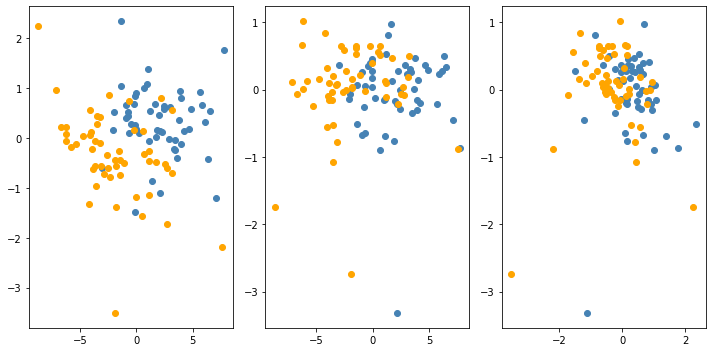

In [9]:
%matplotlib inline
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

axes[0].scatter(projs[:53, 0], projs[:53, 1], c="steelblue")
axes[0].scatter(projs[53:, 0], projs[53:, 1],  c="orange")

axes[1].scatter(projs[:53, 0], projs[:53, 2], c="steelblue")
axes[1].scatter(projs[53:, 0], projs[53:, 2],  c="orange")

axes[2].scatter(projs[:53, 1], projs[:53, 2], c="steelblue")
axes[2].scatter(projs[53:, 1], projs[53:, 2],  c="orange")

plt.tight_layout()

In [10]:
import seaborn as sns
from scipy.interpolate import UnivariateSpline, PchipInterpolator
from pwass.utils import pushforward_density
from scipy.integrate import cumtrapz, simps

def pushforward_quantile(transport, unif_grid):
    dens, eval_grid = pushforward_density(transport, unif_grid)
    cdf = np.concatenate([[0], cumtrapz(dens, eval_grid)])
    return cdf, eval_grid

def invcdf_to_pdf(zero_one_grid, invcdf_eval, s=0.1):
    kept = np.unique(invcdf_eval, return_index=True)[1]
    new_grid = np.linspace(np.min(invcdf_eval), np.max(invcdf_eval), 100)
    cdf = UnivariateSpline(x=invcdf_eval[kept], y=zero_one_grid[kept], s=s)
    der = cdf.derivative()(new_grid)
    return new_grid, der


def plot_npc(pca, ind, pos_lambdas, neg_lambdas, pos_palette, neg_palette, ax, smooth_val):
    for j, lam in enumerate(pos_lambdas):
        proj = pca.bary + pca.project(lam * pca.eig_vecs[:, ind])
        grid, pdf = invcdf_to_pdf(
            zero_one_grid,
            spline_basis.eval_spline(proj), smooth_val)
        neg = np.where(pdf < 0)[0]
        if len(neg):
            pdf[0:neg[-1]] = 0.0
        ax.plot(grid, pdf, color=pos_palette[j])
        
        
    for j, lam in enumerate(neg_lambdas):
        proj = pca.bary + pca.project(lam * pca.eig_vecs[:, ind])
        grid, pdf = invcdf_to_pdf(
            zero_one_grid,
            spline_basis.eval_spline(proj), smooth_val)
        neg = np.where(pdf < 0)[0]
        if len(neg):
            pdf[0:neg[-1]] = 0.0
        ax.plot(grid, pdf, color=neg_palette[j])
        
def plot_ppc(pca, ind, pos_lambdas, neg_lambdas, pos_palette, neg_palette, ax, smooth_val):
    for j, lam in enumerate(pos_lambdas):
        tmp1 = np.matmul(pca.base_change.T, lam * pca.eig_vecs[:, ind])[:pca.k]
        tmp2 = pca.project_on_sub(tmp1)
        proj = pca.bary + pca.pt_from_proj(tmp2)
        grid, pdf = invcdf_to_pdf(
            zero_one_grid,
            spline_basis.eval_spline(proj), smooth_val)
        neg = np.where(pdf < 0)[0]
        if len(neg):
            pdf[0:neg[-1]] = 0.0
        ax.plot(grid, pdf, color=pos_palette[j])
        
        
    for j, lam in enumerate(neg_lambdas):
        proj = pca.bary + pca.project(lam * pca.eig_vecs[:, ind])
        grid, pdf = invcdf_to_pdf(
            zero_one_grid,
            spline_basis.eval_spline(proj), smooth_val)
        neg = np.where(pdf < 0)[0]
        if len(neg):
            pdf[0:neg[-1]] = 0.0
        ax.plot(grid, pdf, color=neg_palette[j])
        
        
def plot_log_pc(proj_pca, ind, pos_lambdas, neg_lambdas, pos_palette, neg_palette, ax, smooth_val):
    for j, lam in enumerate(pos_lambdas):
        proj = proj_pca.bary + (lam * pca.eig_vecs[:, ind])
        transport = spline_basis.eval_spline(proj)
        qgrid, qeval = pushforward_quantile(transport, zero_one_grid)
        grid, pdf = invcdf_to_pdf(qgrid, qeval, smooth_val)
        neg = np.where(pdf < 0)[0]
        if len(neg):
            pdf[0:neg[-1]] = 0.0
        ax.plot(grid, pdf, color=pos_palette[j])
        
        
    for j, lam in enumerate(neg_lambdas):
        proj = proj_pca.bary + (lam * pca.eig_vecs[:, ind])
        transport = spline_basis.eval_spline(proj)
        qgrid, qeval = pushforward_quantile(transport, zero_one_grid)
        grid, pdf = invcdf_to_pdf(qgrid, qeval, smooth_val)
        neg = np.where(pdf < 0)[0]
        if len(neg):
            pdf[0:neg[-1]] = 0.0
        ax.plot(grid, pdf, color=neg_palette[j])

In [11]:
ppca.fit(alldistribs, 2)
pca = ppca
ind = 0
lam = -1000
tmp1 = np.matmul(pca.base_change.T, lam * pca.eig_vecs[:, ind])[:pca.k]
pca.project_on_sub(tmp1)

array([30.16741246,  2.06608389])

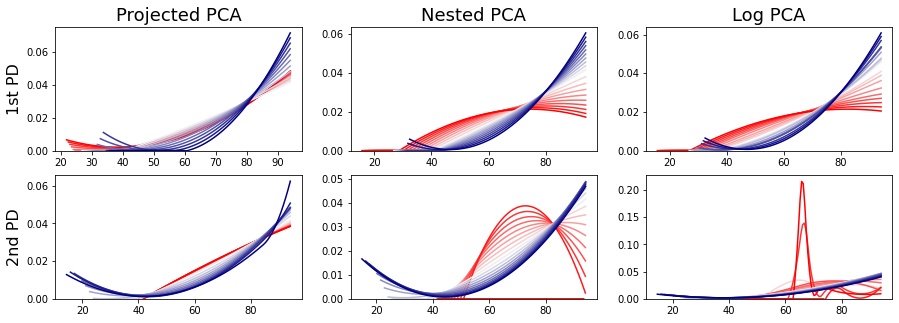

In [226]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 5))

s_vals = [0.1, 0.1]


#ppca.fit(alldistribs, 10)
#npca.fit(alldistribs, 5)
pos_lambdas = np.linspace(0.01, 10, 10)
neg_lambdas = np.linspace(-0.01, -8, 10)
plot_ppc(pca, 0, pos_lambdas, neg_lambdas, pos_palette, neg_palette, axes[0][0], s_vals[0])

pos_lambdas = np.linspace(0.01, 10, 10)
neg_lambdas = np.linspace(-0.01, -5, 10)
plot_npc(npca, 0, pos_lambdas, neg_lambdas, pos_palette, neg_palette, axes[0][1], s_vals[0])
plot_log_pc(ppca, 0, pos_lambdas, neg_lambdas, pos_palette, neg_palette, axes[0][2], s_vals[0])


pos_lambdas = np.linspace(0.01, 6, 10)
neg_lambdas = np.linspace(-0.01, -6, 10)

plot_ppc(pca, 1, pos_lambdas, neg_lambdas, pos_palette, neg_palette, axes[1][0], s_vals[0])
plot_npc(npca, 1, pos_lambdas, neg_lambdas, pos_palette, neg_palette, axes[1][1], s_vals[0] + 1)
plot_log_pc(ppca, 1, pos_lambdas, neg_lambdas, pos_palette, neg_palette, axes[1][2], s_vals[0])

axes[0][0].set_ylabel("1st PD", fontsize=16)
axes[1][0].set_ylabel("2nd PD", fontsize=16)

axes[0][0].set_title("Projected PCA", fontsize=18)
axes[0][1].set_title("Nested PCA", fontsize=18)
axes[0][2].set_title("Log PCA", fontsize=18)


for ax in axes.flat:
    ax.set_ylim(bottom=0.0)

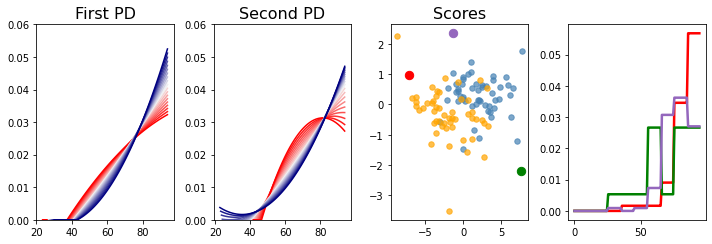

In [200]:
%matplotlib inline

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3.5))

pca = ppca
s_vals = [1.5, 2.5]

pos_lambdas = np.linspace(0.01, 3, 10)
neg_lambdas = np.linspace(-0.01, -3, 10)
pos_palette = sns.light_palette("red", n_colors=len(pos_lambdas))
neg_palette = sns.light_palette("navy", n_colors=len(neg_lambdas))
plot_pc(pca, 0, pos_lambdas, neg_lambdas, pos_palette, neg_palette, axes[0], s_vals[0])



pos_lambdas = np.linspace(0.01, 2.5, 10)
neg_lambdas = np.linspace(-0.01, -2, 10)
pos_palette = sns.light_palette("red", n_colors=len(pos_lambdas))
neg_palette = sns.light_palette("navy", n_colors=len(neg_lambdas))
plot_pc(pca, 1, pos_lambdas, neg_lambdas, pos_palette, neg_palette, axes[1], s_vals[0])


axes[0].set_ylim((0, 0.06))
axes[1].set_ylim((0, 0.06))

i1 = 72
i2 = 54
i3 = 50

lw = 2.5

axes[2].scatter(projs[:53, 0], projs[:53, 1], c="steelblue", s=30, alpha=0.7)
axes[2].scatter(projs[53:, 0], projs[53:, 1],  c="orange", s=30, alpha=0.7)

axes[3].plot(alldistribs[i1].pdf_grid, alldistribs[i1].pdf_eval, 
             label=state_names[i1 - 53], c="red", linewidth=lw)
axes[3].plot(alldistribs[i2].pdf_grid, alldistribs[i2].pdf_eval, 
             c="green", linewidth=lw)
axes[3].plot(alldistribs[i3].pdf_grid, alldistribs[i3].pdf_eval, 
             label=state_names[i3 - len(dfs_by_state)], c="#9467bd", linewidth=lw)



axes[2].scatter(projs[i1, 0], projs[i1, 1], c="red", s=70)
axes[2].scatter(projs[i2, 0], projs[i2, 1],  c="green", s=70)
axes[2].scatter(projs[i3, 0], projs[i3, 1],  c="#9467bd", s=70)

axes[0].set_title("First PD", fontsize=16)
axes[1].set_title("Second PD", fontsize=16)
axes[2].set_title("Scores", fontsize=16)

plt.tight_layout()
# plt.savefig("covid_pc.pdf")

In [ ]:
# log-PCA: takes the raw scores from the ProjPCA, then 'exp'

In [12]:
# Reconstruction error

def reconstruction_error(true_distribs, pca):
    proj_coeffs = pca.transform(true_distribs)
    reconstructed_coeffs = pca.pt_from_proj(proj_coeffs) + pca.bary

    mean = 0
    for i in range(len(true_distribs)):
        pt = true_distribs[i].quantile_coeffs
        delta = pt - reconstructed_coeffs[i, :]
        mean += np.sqrt(pca.inner_prod(delta, delta))

    return mean / len(true_distribs)

def reconstruction_error_norm(true_distribs, pca):
    proj_coeffs = pca.transform(true_distribs)
    reconstructed_coeffs = pca.pt_from_proj(proj_coeffs) + pca.bary

    mean = 0
    for i in range(len(true_distribs)):
        pt = true_distribs[i].quantile_coeffs
        delta = pt - reconstructed_coeffs[i, :]
        dist_mean = pt - pca.bary
        mean += np.sqrt(pca.inner_prod(delta, delta)) / \
                np.sqrt(pca.inner_prod(dist_mean, dist_mean))

    return mean / len(true_distribs)


def fit_and_compute_error(data, pca, dim):
    pca.fit(data, dim)
    error = reconstruction_error(data, pca)
    print("dim: {0}, error: {1}".format(dim, error))
    return error


def ghost_variance(data, pca, dim):
    pca.fit(data, dim)
    X = ppca.get_spline_mat(data)
    l2proj = np.matmul(X - pca.bary, pca.base_change.T)[:, :dim]
    projs = pca.transform(data)
    recl2 = pca.pt_from_proj(l2proj) + pca.bary
    recproj = pca.pt_from_proj(projs) + pca.bary
    
    gv = 0
    for i in range(len(data)):
        delta = recproj[i, :] - recl2[i, :]
        pt = data[i].quantile_coeffs
        num = ppca.inner_prod(delta, delta)
        den = ppca.inner_prod(pt - pca.bary, pt - pca.bary)
        gv += np.sqrt(num / den)
    return gv / len(data)


def compute_errors(pca):
    errs = []
    mean_err = 0
    for d in alldistribs:
        delta = d.quantile_coeffs - ppca.bary
        mean_err += ppca.inner_prod(delta, delta)

    errs.append(mean_err / len(alldistribs))
    
    for dim in range(1, 10):
        errs.append(fit_and_compute_error(alldistribs, pca, dim))

    errs = np.array(errs) / errs[0]
    return errs


def compute_log_errors(lpca):
    errs = []
    lpca.fit(alldistribs, 2)
    mean_err = 0
    for d in alldistribs:
        delta = d.quantile_coeffs - lpca.bary
        mean_err += lpca.inner_prod(delta, delta)
    errs.append(mean_err / len(alldistribs))
    
    for dim in range(1, 10):
        lpca.fit(alldistribs, dim)
        X = ppca.get_spline_mat(alldistribs)
        coeffs = np.matmul(X - lpca.bary, lpca.base_change.T)[:, :lpca.k]
        tmp = np.dot(coeffs, lpca.eig_vecs[:, :lpca.k].T)
        reconstructed_coeffs = lpca.bary + tmp
        mean = 0
        for i in range(len(alldistribs)):
            pt = alldistribs[i].quantile_coeffs
            transport = spline_basis.eval_spline(reconstructed_coeffs[i, :])
            qgrid, qeval = pushforward_quantile(transport, zero_one_grid)
            rec = Distribution(wbasis=spline_basis)
            rec.init_from_quantile(qgrid, qeval)
            rec.compute_spline_expansions()
            
            delta = pt - rec.quantile_coeffs
            mean += np.sqrt(lpca.inner_prod(delta, delta))
        errs.append(mean / len(alldistribs))
    return np.array(errs) / errs[0] 

In [177]:
log_err = compute_log_errors(ppca)

In [174]:
log_err[0]

13.5900077467605

In [175]:
ppca_err[0]

1.0

dim: 1, error: 0.9615325029871199
dim: 2, error: 0.710136119570411
dim: 3, error: 0.5065519249863537
dim: 4, error: 0.29988952259178014
dim: 5, error: 0.19911687208004056
dim: 6, error: 0.1421141734223471
dim: 7, error: 0.10741066489328414
dim: 8, error: 0.08030065570561325
dim: 9, error: 0.05679101322932049
dim: 1, error: 0.9615325002325119
dim: 2, error: 0.664546837923508
dim: 3, error: 0.4634987896368924
dim: 4, error: 0.281733387768653
dim: 5, error: 0.21425535670525067
dim: 6, error: 0.14990614853223094
dim: 7, error: 0.11070373637330351
dim: 8, error: 0.0802197313099801
dim: 9, error: 0.06324925871266787


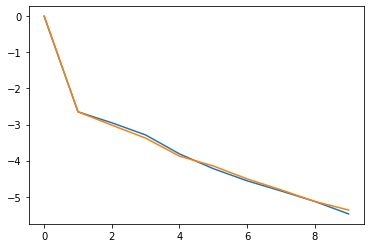

In [113]:
ppca_err = compute_errors(ppca)
npca_err = compute_errors(npca)

In [182]:
(ppca_err - npca_err) / npca_err

array([ 0.00000000e+00,  2.86481002e-09,  6.86020594e-02,  9.28872660e-02,
        6.44443847e-02, -7.06562714e-02, -5.19790228e-02, -2.97467058e-02,
        1.00878418e-03, -1.02107845e-01])

In [180]:
npca_err

array([1.        , 0.0707529 , 0.04889967, 0.03410585, 0.02073092,
       0.01576565, 0.01103062, 0.00814597, 0.00590285, 0.0046541 ])

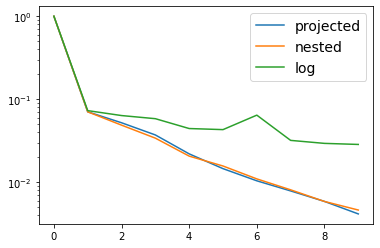

In [276]:
plt.plot(ppca_err, label="projected")
plt.plot(npca_err, label="nested")
plt.plot(log_err, label="log")
plt.yscale("log")
plt.legend(fontsize=14)
plt.savefig("covid_rec_err.pdf")

In [86]:
errs = []
gv = []
mean_err = 0
for d in alldistribs:
    delta = d.quantile_coeffs - ppca.bary
    mean_err += ppca.inner_prod(delta, delta)

errs.append(mean_err / len(alldistribs))
gv.append(1)

for dim in range(1, 10):
    errs.append(fit_and_compute_error(alldistribs, ppca, dim))
    gv.append(ghost_variance(alldistribs, ppca, dim))
    
errs = np.array(errs) / errs[0]

dim: 1, error: 0.9615325029871199
dim: 2, error: 0.710136119570411
dim: 3, error: 0.5065519249863537
dim: 4, error: 0.29988952259178014
dim: 5, error: 0.19911687208004056
dim: 6, error: 0.1421141734223471
dim: 7, error: 0.10741066489328414
dim: 8, error: 0.08030065570561325
dim: 9, error: 0.05679101322932049


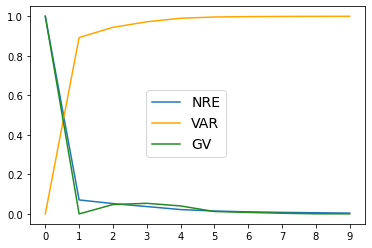

In [87]:
fig,ax = plt.subplots()

ax.plot(range(10), errs, label="NRE")
ax.set_xticks(range(10))

variances = np.cumsum(ppca.eig_vals[:9]) / np.sum(ppca.eig_vals)
variances = np.r_[0, variances]

ax.plot(range(0, 10), variances,label="VAR", color="orange")
ax.plot(range(0, 10), gv, label="GV", color="forestgreen")

fig.legend(fontsize=14, loc="center")
# plt.savefig("covid_pca_rec.pdf")

In [13]:
def get_eta(ind, pca, etamax=10):
    eta_grid = np.linspace(0, etamax, 1000)
    is_monotone = pca.bary + pca.eig_vecs[:, ind] * eta_grid[:, np.newaxis]
    is_monotone = np.all(np.diff(is_monotone, axis=1) > 0, axis=1)
    return eta_grid[is_monotone][-1]

In [14]:
ppca.fit(alldistribs, 2)
projs = ppca.transform(alldistribs)
X = ppca.get_spline_mat(alldistribs)
X_trans = np.matmul(X - ppca.bary, ppca.base_change.T)[:, :ppca.k]

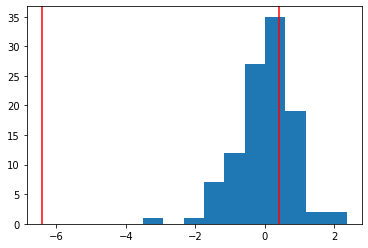

In [225]:
etamax = get_eta(1, ppca, 100)
etamin = get_eta(1, ppca, -100)

plt.hist(X_trans[:, 1])
plt.axvline(etamax, color="red")
plt.axvline(etamin, color="red")

In [220]:
etamin

-8.70870870870871

In [ ]:
ind = 0
s = X_trans[:, ind]
np.sum(s[s < etamin] - etamin) / len(alldistribs)

In [ ]:
ind = 1
etamax = get_eta(ind, ppca, 10)
etamin = get_eta(ind, ppca, -10)

plt.hist(X_trans[:, ind])
plt.axvline(etamax, color="red")
plt.axvline(etamin, color="red")

In [ ]:
s = X_trans[:, ind]
1 - np.sum((s[s > etamax] - etamax) / s[s > etamax]) / len(alldistribs)

In [103]:
lam = 10
ppca.bary + pca.project(lam * ppca.eig_vecs[:, ind])

array([15.71207811, 45.67571655, 47.59710759, 55.58300385, 58.13922103,
       62.22081475, 64.73506458, 68.41294597, 71.23956096, 74.66910085,
       78.08641407, 81.39028862, 85.11228289, 90.56820121, 93.9983258 ])